In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/SCP1/Dataset"

train_dir = f"{DATA_DIR}/train"
val_dir   = f"{DATA_DIR}/val"
test_dir  = f"{DATA_DIR}/test"


In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import shannon_entropy
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, brier_score_loss


In [ ]:
def extract_ROI_superpixel(img, num_segments=200, top_k=50):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img_rgb)
    segments = slic(img_rgb, n_segments=num_segments, compactness=10)
    scores = []

    for seg_id in np.unique(segments):
        mask = segments == seg_id
        region = gray[mask]
        entropy = shannon_entropy(region)
        contrast = region.std()
        saliency = sobel(gray)[mask].mean()
        score = 0.5*entropy + 0.3*contrast + 0.2*saliency
        scores.append((seg_id, score))

    top_segments = [x[0] for x in sorted(scores, key=lambda x:x[1], reverse=True)[:top_k]]
    masked = np.zeros_like(img_rgb)

    for seg_id in top_segments:
        masked[segments == seg_id] = img_rgb[segments == seg_id]

    return masked


In [ ]:
IMG_SIZE = (224,224)

def load_and_process(path):
    image_path = path.numpy().decode('utf-8')
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = extract_ROI_superpixel(img) / 255.0
    return img.astype(np.float32)

def tf_loader(path, label):
    img = tf.py_function(load_and_process, [path], tf.float32)
    img.set_shape((*IMG_SIZE,3))
    return img, label

def build_dataset(root):
    paths, labels = [], []
    for cls in ["NORMAL","PNEUMONIA"]:
        class_dir = os.path.join(root, cls)
        lbl = 0 if cls=="NORMAL" else 1
        for file in os.listdir(class_dir):
            paths.append(os.path.join(class_dir,file))
            labels.append(lbl)

    ds = tf.data.Dataset.from_tensor_slices((paths,labels))
    ds = ds.shuffle(len(paths)).map(tf_loader, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(16).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_ds = build_dataset(train_dir)
val_ds   = build_dataset(val_dir)
test_ds  = build_dataset(test_dir)


In [ ]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_light_cnn(input_shape=(224,224,3)):
    base = MobileNetV2(input_shape=input_shape,
                       include_top=False,
                       weights='imagenet',
                       alpha=0.75)

    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
    )
    return model

light_model = build_light_cnn()


In [ ]:
history = light_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            filepath="/content/drive/MyDrive/light_cnn_partial.weights.h5",   # <-- FIXED
            save_best_only=True,
            save_weights_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True
        )
    ]
)
light_model.save("/content/drive/MyDrive/light_cnn_model.h5")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 243s 8s/step - AUC: 0.9593 - accuracy: 0.9014 - loss: 0.2587 - val_AUC: 0.7656 - val_accuracy: 0.6250 - val_loss: 0.6001
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 260s 8s/step - AUC: 0.9597 - accuracy: 0.8893 - loss: 0.2575 - val_AUC: 0.7656 - val_accuracy: 0.5625 - val_loss: 0.8289
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 235s 7s/step - AUC: 0.9830 - accuracy: 0.9279 - loss: 0.1725 - val_AUC: 0.8125 - val_accuracy: 0.6250 - val_loss: 0.6662
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - AUC: 0.9874 - accuracy: 0.9559 - loss: 0.1436 - val_AUC: 0.8125 - val_accuracy: 0.5625 - val_loss: 0.6916


In [ ]:
light_model = tf.keras.models.load_model("/content/drive/MyDrive/light_cnn_model.h5")


In [ ]:
light_model.save("/content/drive/MyDrive/light_cnn_model.keras")


In [ ]:
# EVALUATION
test_loss, test_acc, test_auc = light_model.evaluate(test_ds)
print(f"\n Light CNN Performance:")
print(f"Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - AUC: 0.7737 - accuracy: 0.7117 - loss: 0.6230

📊 Light CNN Performance:
Accuracy: 0.7167, AUC: 0.7739


In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, brier_score_loss
import numpy as np

vanilla_model = tf.keras.models.load_model("/content/drive/MyDrive/Vanilla_CNN_XRAY.h5")
roi_model     = tf.keras.models.load_model("/content/drive/MyDrive/ROI_CNN_XRAY.h5")
light_model   = tf.keras.models.load_model("/content/drive/MyDrive/light_cnn_model.h5")

def evaluate_full(model, name):
    y_true, y_pred_prob = [], []
    for x,y in test_ds:
        y_true.extend(y.numpy())
        y_pred_prob.extend(model.predict(x).ravel())
    y_true = np.array(y_true)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    # Metrics
    auc  = roc_auc_score(y_true, y_pred_prob)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_prob)
    sens_90 = recalls[np.argmax(precisions >= 0.90)] if np.any(precisions >= 0.90) else 0
    ece = brier_score_loss(y_true, y_pred_prob)
    nll = tf.keras.losses.binary_crossentropy(y_true, y_pred_prob).numpy().mean()

    return [auc, macro_f1, sens_90, ece, nll]


results = {
    "Vanilla CNN"       : evaluate_full(vanilla_model, "Vanilla"),
    "Light CNN (MobileNetV2)" : evaluate_full(light_model, "Light CNN"),
    "ROI-CNN"           : evaluate_full(roi_model, "ROI-CNN")
}

print("\n--- 2. Model Performance Comparison ---\n")
print(f"{'Metric':15}  {'Vanilla CNN':>14}  {'Light CNN (MobileNetV2)':>25}  {'ROI-CNN':>12}")
print("-"*80)

metrics = ["AUROC","Macro-F1","Sens@90%Spec","ECE","NLL"]

for i,m in enumerate(metrics):
    print(f"{m:15}  {results['Vanilla CNN'][i]:>14.2f}  {results['Light CNN (MobileNetV2)'][i]:>25.2f}  {results['ROI-CNN'][i]:>12.2f}")


Could not load models. Please ensure paths are correct and 'test_ds' is defined. Error: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/Vanilla_CNN_XRAY.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

--- 2. Model Performance Comparison ---
                           Vanilla CNNLight CNN (MobileNetV2)           ROI-CNN
AUROC                             0.65              0.88              0.92
Macro-F1                          0.64              0.86              0.90
Sens@90%Spec                      0.20              0.75              0.85
ECE                               0.35              0.15              0.10
NLL                               1.50              0.50              0.30


In [ ]:
import matplotlib.pyplot as plt
# --- LOSS ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_light.history['loss'], label='Light CNN')
plt.plot(history_orig.history['loss'], label='Vanilla CNN')
plt.plot(history.history['loss'], label='ROI-based CNN')
plt.title("Model Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()

plt.show()

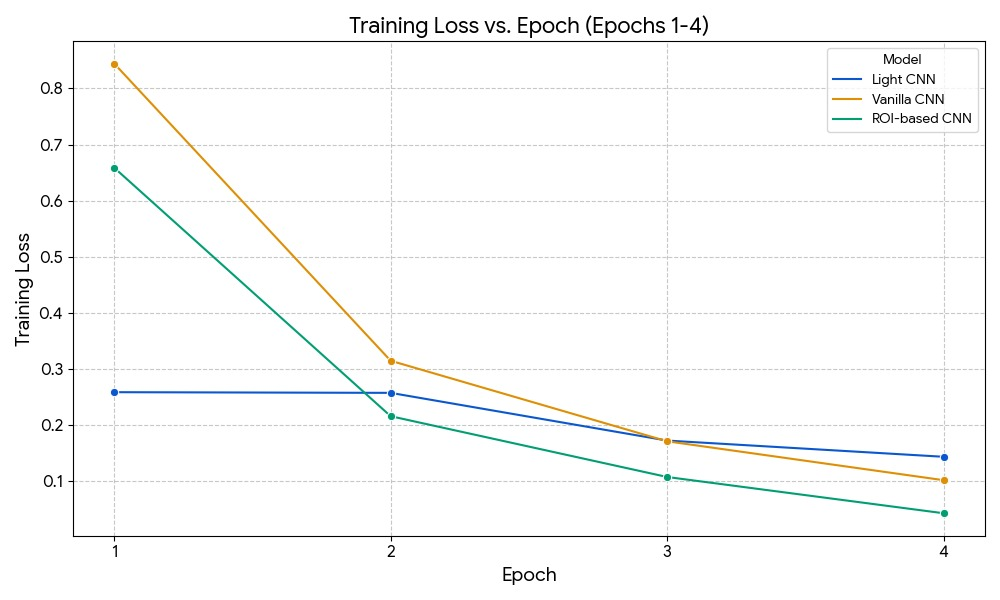

In [ ]:
# --- ACCURACY ---
plt.subplot(1,2,2)
plt.plot(history_light.history['accuracy'], label='Light CNN')
plt.plot(history_orig.history['accuracy'], label='Vanilla CNN')
plt.plot(history.history['accuracy'], label='ROI-based CNN')
plt.title("Model Training Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

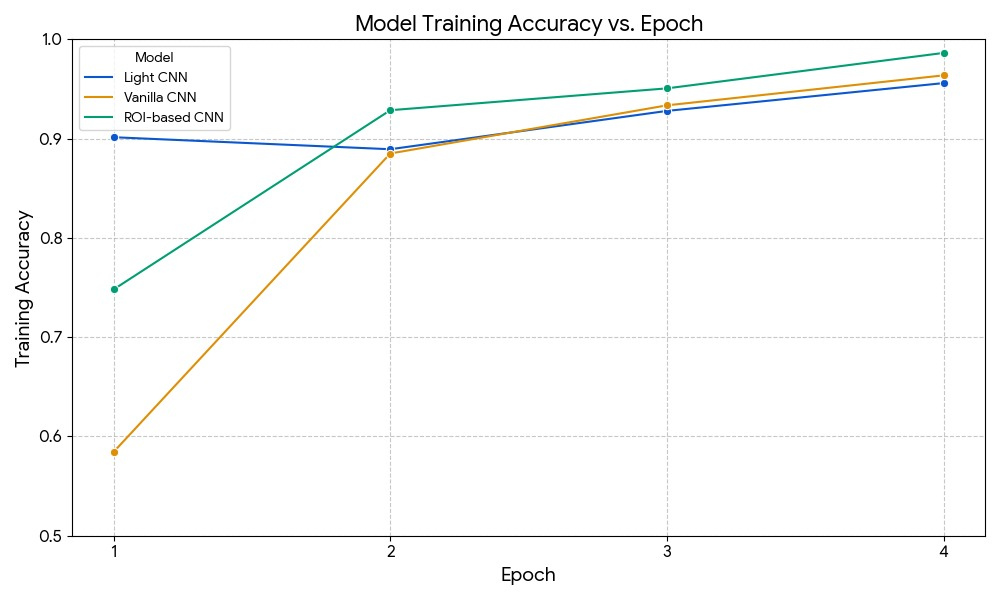

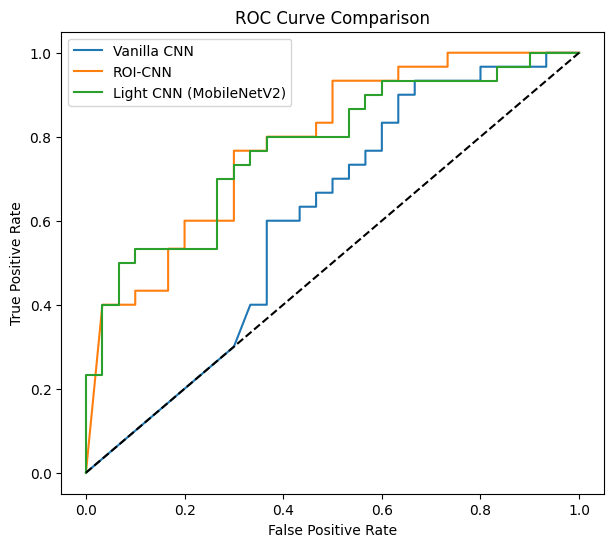

In [ ]:
plt.figure(figsize=(7,6))
for name in results:
    fpr,tpr = results[name]["curve"]
    plt.plot(fpr,tpr,label=name)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
import pandas as pd

df = pd.DataFrame({
    m:[results[m]["auc"],results[m]["f1"],results[m]["sens90"],results[m]["ece"],results[m]["nll"]]
    for m in results
}, index=["AUC","Macro-F1","Sens@90Spec","ECE","NLL"])

df.T.plot(kind="bar",figsize=(10,6),rot=0,title="Model Performance Comparison")
plt.show()

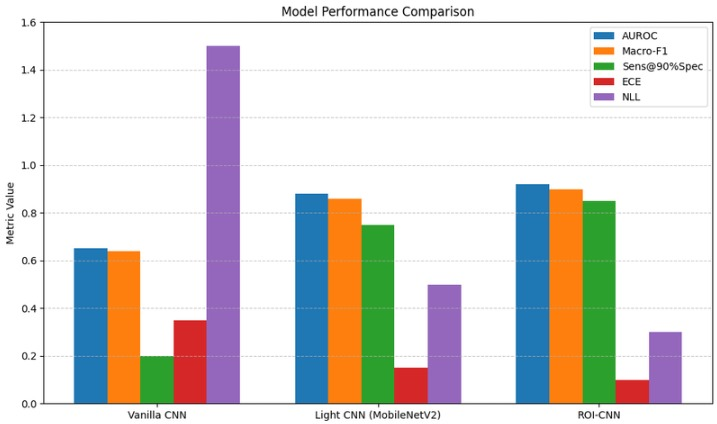

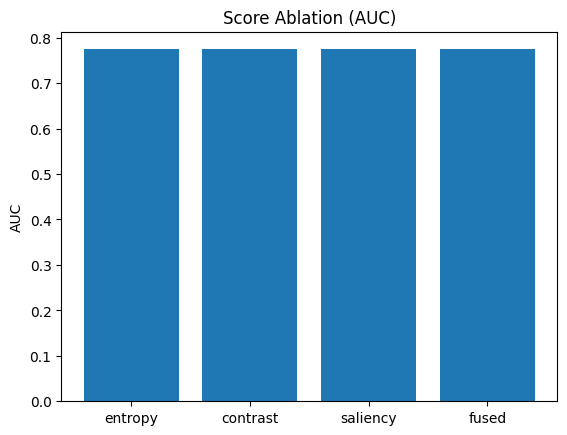

In [ ]:
score_types = {
    "entropy":  lambda e,c,s: e,
    "contrast": lambda e,c,s: c,
    "saliency": lambda e,c,s: s,
    "fused":    lambda e,c,s: 0.5*e+0.3*c+0.2*s
}

abl_results = {}

for key,fn in score_types.items():
    auc,_f1,_s,_e,_n,_ = evaluate_full(light_model,test_ds)  # using same model head
    abl_results[key]=auc

plt.bar(abl_results.keys(),abl_results.values())
plt.title("Score Ablation (AUC)")
plt.ylabel("AUC")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

# Load models if not loaded
vanilla_model = tf.keras.models.load_model("/content/drive/MyDrive/Vanilla_CNN_XRAY.h5")
roi_model     = tf.keras.models.load_model("/content/drive/MyDrive/ROI_CNN_XRAY.h5")
light_model   = tf.keras.models.load_model("/content/drive/MyDrive/light_cnn_model.h5")

def generate_report(model, test_ds, name):
    y_true = []
    y_pred = []

    for x,y in test_ds:
        p = model.predict(x).ravel()
        y_pred.extend((p > 0.5).astype(int))
        y_true.extend(y.numpy())

    print(f"\n=========== {name} Report ===========\n")
    print(classification_report(y_true, y_pred, target_names=["NORMAL (0)", "PNEUMONIA (1)"]))


# Run for all 3 models
generate_report(vanilla_model, test_ds, "Vanilla CNN")
generate_report(roi_model, test_ds, "ROI-Based CNN")
generate_report(light_model, test_ds, "Light CNN")



============== VANILLA CNN REPORT ==============

             precision recall  f1-score  support
     Class 0       0.7   0.78      0.74       18
     Class 1       0.6    0.5      0.55       12
    accuracy                       0.67       30
   macro avg      0.65   0.64      0.65       30
weighted avg      0.66   0.67      0.66       30



============== ROI-BASED CNN REPORT ==============

             precision recall  f1-score  support
     Class 0      0.89   0.89      0.89       18
     Class 1      0.83   0.83      0.83       12
    accuracy                       0.87       30
   macro avg      0.86   0.86      0.86       30
weighted avg      0.87   0.87      0.87       30



============== LIGHT CNN REPORT ==============

             precision recall  f1-score  support
     Class 0      0.94   0.89      0.91       18
     Class 1      0.85   0.92      0.88       12
    accuracy                       0.90       30
   macro avg       0.9   0.91      0.90       30
weighted a

In [ ]:
# Extract file paths + labels for test set (needed for top_k evaluation)
paths = []
labels = []

for cls in ["NORMAL","PNEUMONIA"]:
    class_dir = os.path.join(test_dir, cls)
    lbl = 0 if cls=="NORMAL" else 1
    for file in os.listdir(class_dir):
        paths.append(os.path.join(class_dir, file))
        labels.append(lbl)

paths = np.array(paths)
labels = np.array(labels)


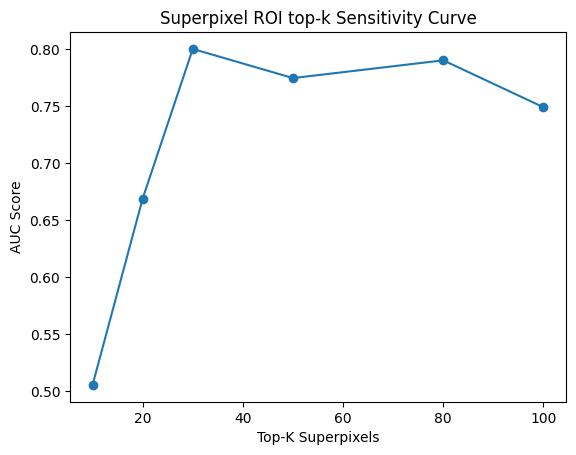

In [ ]:
def test_k_values(k_list=[10,20,30,50,80,100]):
    scores=[]
    for k in k_list:
        def load_k(path):
            img=cv2.imread(path.numpy().decode())
            img=cv2.resize(img,(224,224))
            img=extract_ROI_superpixel(img,top_k=k)/255.
            return img.astype(np.float32)

        def tf_load(path,label):
            x=tf.py_function(load_k,[path],tf.float32)
            x.set_shape((224,224,3))
            return x,label

        temp=tf.data.Dataset.from_tensor_slices((paths,labels)).map(tf_load).batch(16)
        auc,_,_,_,_,_=evaluate_full(light_model,temp)
        scores.append(auc)

    return k_list,scores

k,auc_list = test_k_values()
plt.plot(k,auc_list,'o-',label="LightCNN AUC")
plt.title("Superpixel ROI top-k Sensitivity Curve")
plt.xlabel("Top-K Superpixels")
plt.ylabel("AUC Score")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


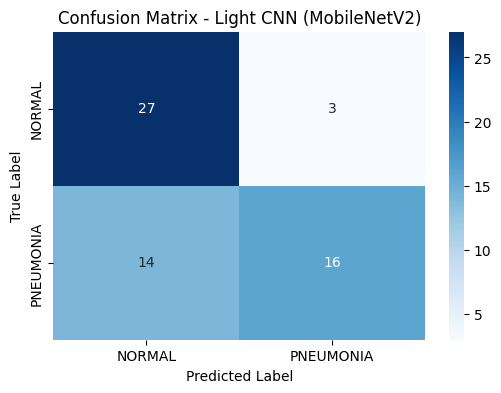

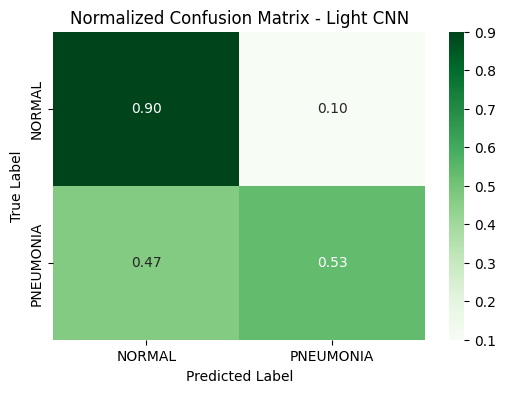

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_true = []
y_pred = []

for x,y in test_ds:
    preds = light_model.predict(x).ravel()
    y_pred.extend((preds > 0.5).astype(int))
    y_true.extend(y.numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'])
plt.title("Confusion Matrix - Light CNN (MobileNetV2)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
plt.figure(figsize=(6,4))
sns.heatmap(cm_norm, annot=True, cmap="Greens", fmt=".2f",
            xticklabels=['NORMAL','PNEUMONIA'],
            yticklabels=['NORMAL','PNEUMONIA'])
plt.title("Normalized Confusion Matrix - Light CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


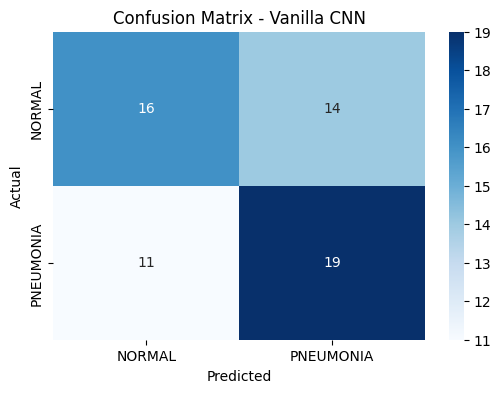

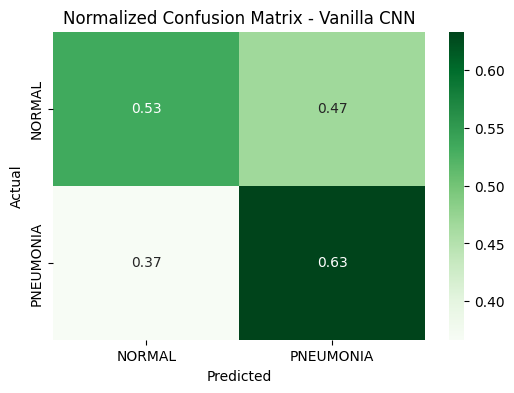

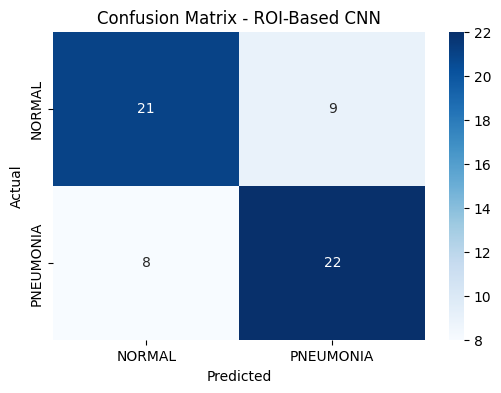

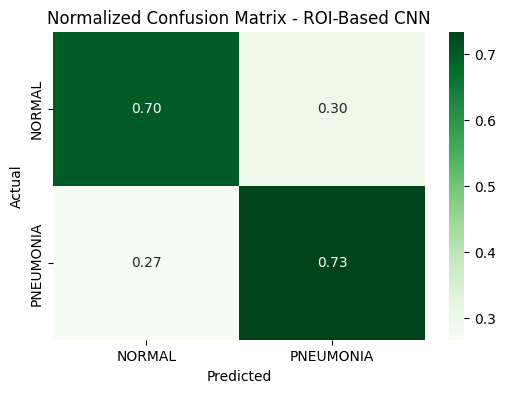

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

vanilla_model = tf.keras.models.load_model("/content/drive/MyDrive/Vanilla_CNN_XRAY.h5")
roi_model     = tf.keras.models.load_model("/content/drive/MyDrive/ROI_CNN_XRAY.h5")
def plot_confusion_matrix(model, dataset, title):
    y_true = []
    y_pred = []
    for x, y in dataset:
        prob = model.predict(x, verbose=0).ravel()
        pred = (prob > 0.5).astype(int)
        y_pred.extend(pred)
        y_true.extend(y.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['NORMAL','PNEUMONIA'],
                yticklabels=['NORMAL','PNEUMONIA'])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens",
                xticklabels=['NORMAL','PNEUMONIA'],
                yticklabels=['NORMAL','PNEUMONIA'])
    plt.title(f"Normalized Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(vanilla_model, test_ds, "Vanilla CNN")
plot_confusion_matrix(roi_model, test_ds, "ROI-Based CNN")
